<a href="https://colab.research.google.com/github/jayleen003/lstm/blob/main/EfficientNet_Cat_Dog_Classification_TL_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for pillow: filename=Pillow-4.0.0-cp311-cp311-linux_x86_64.whl size=929085 sha256=676b508bea90c27940fd7734bf0bc01d62b0f59625935c119eb9344be28d8cf3
  Stored in directory: /root/.cache/pip/wheels/d9/f3/e1/82815320c60ebe320ab25ab856fa1b22582564ff5cbbccfd82
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.37.0 requires pillow>=8.3.2, but you have pillow 4.0.0 which is incompatible.
matplotlib 3.10.0 requires pillow>=8, but you have pillow 4.0.0 which is incompatible

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
#hyperparameters
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

In [ ]:
#clone efficient repo
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 171 (delta 98), reused 161 (delta 93), pack-reused 0
Receiving objects: 100% (171/171), 5.44 MiB | 12.20 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
#import efficientnet and load the conv base model
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [ ]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
16719872/16717576 [==============================] - 1s 0us/step


In [ ]:
#download cat vs dog dataset
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
  !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
  print("dataset already exist.")

--2019-12-26 08:52:06--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.108.168, 2600:1406:e800:48f::e59, 2600:1406:e800:48e::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.218.108.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   189MB/s    in 4.2s    

2019-12-26 08:52:10 (187 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [ ]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-r--r-- 1 root root   34297 Feb 10  2017 9955.jpg
-rw-r--r-- 1 root root   26013 Feb 10  2017 9956.jpg
-rw-r--r-- 1 root root   26293 Feb 10  2017 9957.jpg
-rw-r--r-- 1 root root   36293 Feb 10  2017 9958.jpg
-rw-r--r-- 1 root root   36690 Feb 10  2017 9959.jpg
-rw-r--r-- 1 root root   15262 Feb 10  2017 9960.jpg
-rw-r--r-- 1 root root   49493 Feb 10  2017 9961.jpg
-rw-r--r-- 1 root root   14785 Feb 10  2017 9962.jpg
-rw-r--r-- 1 root root   39717 Feb 10  2017 9963.jpg


In [ ]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [ ]:
# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 24s 589ms/step - loss: 2.0743 - acc: 0.4734 - val_loss: 1.8288 - val_acc: 0.4375
Epoch 2/20
41/41 [==============================] - 17s 421ms/step - loss: 2.0225 - acc: 0.4749 - val_loss: 1.8197 - val_acc: 0.4479
Epoch 3/20
41/41 [==============================] - 17s 419ms/step - loss: 2.0114 - acc: 0.4836 - val_loss: 1.7132 - val_acc: 0.4615
Epoch 4/20
41/41 [==============================] - 17s 419ms/step - loss: 1.9034 - acc: 0.4826 - val_loss: 1.6235 - val_acc: 0.4708
Epoch 5/20
41/41 [==============================] - 17s 421ms/step - loss: 1.9148 - acc: 0.4985 - val_loss: 1.5211 - val_acc: 0.4917
Epoch 6/20
41/41 [==============================] - 17s 418ms/step - loss: 1.8250 - acc: 0.5020 - val_loss: 1.4405 - val_acc: 0.5104

Epoch 7/20
41/41 [==============================] - 17s 424ms/step - loss: 1.7772 - acc: 0.5225 - val_loss: 1.3895 - val_acc: 0.5323
Epoch 8/20
41/41 [==============================] - 17s 423ms/step -

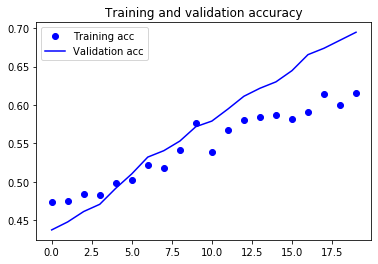

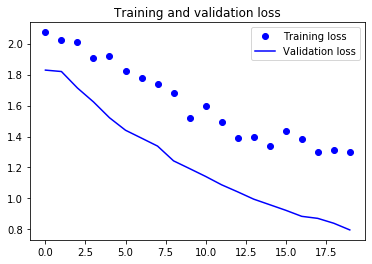

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#fine tuning last layers
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 18s 433ms/step - loss: 1.2624 - acc: 0.6142 - val_loss: 0.7718 - val_acc: 0.6990
Epoch 2/20
41/41 [==============================] - 17s 422ms/step - loss: 1.2666 - acc: 0.6076 - val_loss: 0.7549 - val_acc: 0.7073
Epoch 3/20
41/41 [==============================] - 17s 419ms/step - loss: 1.2318 - acc: 0.6101 - val_loss: 0.7287 - val_acc: 0.7125
Epoch 4/20
41/41 [==============================] - 17s 416ms/step - loss: 1.1728 - acc: 0.6255 - val_loss: 0.7275 - val_acc: 0.7156
Epoch 5/20
41/41 [==============================] - 17s 421ms/step - loss: 1.1434 - acc: 0.6445 - val_loss: 0.6947 - val_acc: 0.7302
Epoch 6/20
41/41 [==============================] - 17s 421ms/step - loss: 1.1053 - acc: 0.6568 - val_loss: 0.6948 - val_acc: 0.7375
Epoch 7/20
41/41 [==============================] - 17s 424ms/step - loss: 1.1182 - acc: 0.6460 - val_loss: 0.6883 - val_acc: 0.7396
Epoch 8/20
41/41 [==============================] - 17s 421ms/step - 

In [ ]:

os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

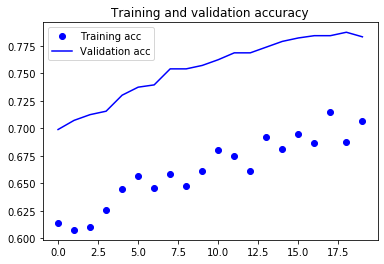

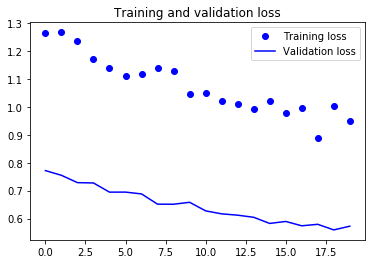

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#test predict
cat_img = cat_images[-1]
dog_img= dog_images[-1]

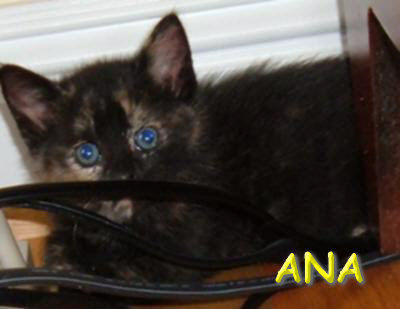

In [ ]:
Image(filename=cat_img)

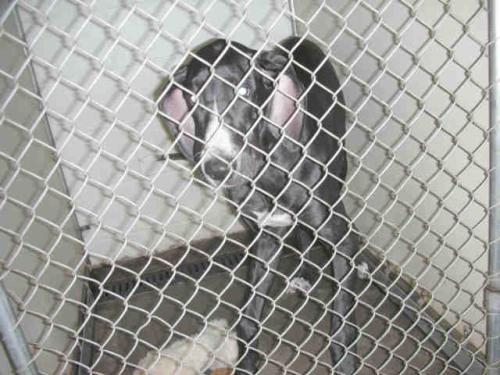

In [ ]:
Image(filename=dog_img)

In [ ]:

from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9135669)
('dog', 0.6510244905948639)


In [ ]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

In [ ]:
model.input_shape

(None, 150, 150, 3)

In [ ]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
